<img align="top" width="125" height="125" src="https://yt3.ggpht.com/ytc/AMLnZu98lem7OMj3mWDcv5V036d4UB9YH7msU1PMWKA1XA=s900-c-k-c0x00ffffff-no-rj" alt="banner">

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Clarifai/colab-notebooks/blob/ps/api-training/inference/dataframe_inference.ipynb)

# General Information

This notebook is to be used to run classification inference on images using a dataframe. In this tutorial, you will learn how to run inference on data in a Clarifai Application and a local test_df.csv file.

To be able to run this notebook, you will need to provide a model ID and model version ID.

## Expected inputs

- The app ID **(required)**
- The user ID **(required)**
- An PAT key token **(required)**
- A model ID **(required)**
- An model version ID **(required)**

## Limitations

- Not meant for inference on videos
- Not meant for inference on images for object detection


# Table of contents

- [Python requirements](#Python-requirements)
- [Imports](#Imports)
- [Setup Variables](#Setup-Variables)
- [Helper functions (ignore)](<#Helper-functions-(ignore)>)
- [Inference via Application DataFrame](#Inference-via-Application-DataFrame)
- [Inference via Local DataFrame](#Inference-via-Local-DataFrame)


# Python requirements

Dependencies:

- clarifai_grpc
- pillow
- pandas
- tqdm
- matplotlib
- scikit-learn

You can run the following cell to install all three required dependencies. They are required for this notebook.


In [ ]:
!pip -q install protobuf==3.19.5
!pip -q install clarifai-grpc==9.0.0
!pip -q install pillow==9.4.0
!pip -q install tqdm==4.64.1
!pip -q install pandas==1.4.3
!pip -q install matplotlib==3.1.3
!pip -q install scikit-learn==1.1.2

# Imports

In this section, we will be importing some of the required libraries.


In [3]:
# Standard imports
import re
import os
import sys
import glob
import time
from typing import Any, List, Tuple, Optional, Dict, Iterator, Iterable
from pathlib import Path
import requests
from io import BytesIO
import random
from concurrent.futures import ThreadPoolExecutor, as_completed

# Imports
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from google.protobuf.struct_pb2 import Struct
from google.protobuf.json_format import MessageToJson, MessageToDict
from sklearn.metrics import classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn import preprocessing

# Clarifai imports
from clarifai_grpc.channel.clarifai_channel import ClarifaiChannel
from clarifai_grpc.grpc.api import resources_pb2, service_pb2, service_pb2_grpc
from clarifai_grpc.grpc.api.status import status_pb2, status_code_pb2


# Setup Variables

Please fill up the following variables. They are needed to run the notebook.


## Authentication

Please fill the following section with your application PAT key (red), user id (blue) and app id (green). The following picture demonstrates where to find the PAT key (red) and the APP ID (green).



<img src="https://i.imgur.com/v86D8GY.png" alt="drawing" width="600" height="550"/>

<img src="https://i.imgur.com/fx29FyC.png" alt="drawing" width="600" height="550"/>


<img src="https://i.imgur.com/9ZeIieK.png" alt="drawing" width="600" height="550"/>

In [4]:
##################################################################################
# In this section, we set the user authentication, app ID, and the workflow id
# that we will be using for predictions. Change these strings to run your own example.
##################################################################################

# Your user id in portal. You can find it under "profile" settings
USER_ID = "INPUT YOUR USER ID HERE"

# Your API key for your application. Make sure the API scopes have Model, Predict and Workflow enabled
PAT = "INPUT YOUR PERSONAL ACCESS TOKEN HERE"

# Your unique application ID. It should be written on the top left when first entering the application home page
APP_ID = "INPUT YOUR APP ID HERE"

## General Global Variables

Global variables that will be reused throughout the notebook. The channel, stub and metadata will be used to call the Clarifai API.

In [5]:
# Construct the communications channel and the object stub to call requests on.
channel = ClarifaiChannel.get_grpc_channel()
stub = service_pb2_grpc.V2Stub(channel)
metadata = (("authorization", "Key " + PAT),)

# The user data object that will be used for all requests when you are using the PAT authentication
# It is not needed if you are calling the API with the API key
userDataObject = resources_pb2.UserAppIDSet(user_id=USER_ID, app_id=APP_ID)

## Model Global Variables
The model ID and the model version ID will be required for inference. Please fill-in these two variables with the model you want to test.

In [6]:
model_ID = "INPUT_HERE_YOUR_MODEL_ID"
version_ID = "INPUT_HERE_YOUR_MODEL_VERSION_ID"

# Helper functions (ignore)

This section contains helper functions that simplify and organize the code. You do not have to modify these functions.


In [7]:
def chunker(seq: Iterable, size: int) -> Iterator[Any]:
    """Function that generates chunks of items from a sequence

    Args:
        seq (sequence object): A sequence of items
        size (int): Size of the chunks to generate

    Yields:
        Iterator[Any]: Yield the next chunk of items
    """
    return (seq[pos : pos + size] for pos in range(0, len(seq), size))


def is_success(response):
    if response.status.code != status_code_pb2.SUCCESS:
        return False
    return True


def is_mixed_success(response):
    if response.status.code != status_code_pb2.MIXED_STATUS:
        return False
    return True


def build_metadata(**kwargs) -> Struct:
    """function that builds a protobuf Struct object for metadata

    Returns:
        protobuf.Struct: protobuf Struct object
    """
    struct = Struct()
    payload = dict(**kwargs)
    struct.update(payload)
    return struct


def local_path_to_image(image_path):
    """Download the image, convert it to a NumPy array, and then read
    it into PIL Image object

    Args:
        image_url (str): URL path of the image

    Returns:
        Image: PIL Image object
    """
    try:
        img = Image.open(image_path)
    except Exception as e:
        print(f"Error: {e}")
        img = None

    return img


def url_to_image(url):
    """Download the image, convert it to a NumPy array, and then read
    it into PIL Image object

    Args:
        image_url (str): URL path of the image

    Returns:
        Image: PIL Image object
    """
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
    except Exception as e:
        print(f"Error: {e}")
        img = None

    return img


def calculate_expected_batch_number(inputs: List[Any], batch_size: int) -> int:
    """Function to calculate the expected number of batches

    Args:
        inputs (List[Any]): List of inputs
        batch_size (int): The number of items in the batch

    Returns:
        int: expected batch number
    """
    expected_batch_nums = (
        (len(inputs) // batch_size) if len(inputs) % batch_size == 0 else (len(inputs) // batch_size + 1)
    )
    return expected_batch_nums


def create_subplot_from_df(
    df, image_path_col="url", concepts_col="pos_concept", num_rows=2, figsize=(10, 10)
):
    df_len = len(df)
    remove_last = False
    if df_len % 2 == 0:
        num_cols = int(df_len / num_rows)
    else:
        remove_last = True
        num_cols = int((df_len + 1) / num_rows)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=figsize)
    axs = axs.flatten()
    for image_path, concept, ax in zip(df[image_path_col], df[concepts_col], axs):
        ax.set_axis_off()
        ax.text(
            0.5,
            0.08,
            f"{concept}",
            fontsize=12,
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax.transAxes,
            bbox=dict(facecolor="green", alpha=0.60),
        )
        if os.path.exists(image_path):
            img = local_path_to_image(image_path)
        else:
            img = url_to_image(image_path)
        ax.imshow(img)
    if remove_last:
        fig.delaxes(axs[-1])  # The indexing is zero-based here

    plt.tight_layout(pad=1, w_pad=0.5, h_pad=1)
    plt.show()


## Helper (Getting Data)

In [8]:
def get_processed_input_count(stub, metadata):
    get_input_count_response = stub.GetInputCount(
        service_pb2.GetInputCountRequest(
            user_app_id=userDataObject,
        ),
        metadata=metadata,
    )

    if get_input_count_response.status.code != status_code_pb2.SUCCESS:
        print(get_input_count_response.status)
        raise Exception("Get input count failed, status: " + get_input_count_response.status.description)

    counts = get_input_count_response.counts
    return counts.processed


def get_inputs_per_page(stub, metadata, page, per_page=1000):
    list_inputs_response = stub.ListInputs(
        service_pb2.ListInputsRequest(user_app_id=userDataObject, page=page, per_page=per_page),
        metadata=metadata,
    )
    if not is_success(list_inputs_response) and not is_mixed_success(list_inputs_response):
        print(list_inputs_response.status)
        raise Exception("List inputs failed, status: " + list_inputs_response.status.description)

    return list_inputs_response


def process_list_inputs_response(list_inputs_response):
    input_success_status = {
        status_code_pb2.INPUT_DOWNLOAD_SUCCESS,
        status_code_pb2.INPUT_DOWNLOAD_PENDING,
        status_code_pb2.INPUT_DOWNLOAD_IN_PROGRESS,
    }

    input_dict_list = []
    for idx, input in enumerate(list_inputs_response.inputs):
        if input.status.code not in input_success_status:
            continue

        # Initializations
        input_dict = {}

        # Get input_id for image
        if input.data.concepts:
            input_dict["input_id"] = input.id
            input_dict["url"] = input.data.image.url
            input_dict["pos_concepts"] = ":".join(
                [concept.id for concept in input.data.concepts if concept.value == 1]
            )
            input_dict["neg_concepts"] = ":".join(
                [concept.id for concept in input.data.concepts if concept.value == 0]
            )
            input_dict_list.append(input_dict)

    return input_dict_list


def get_all_inputs_df(stub, metadata):
    input_success_status = {
        status_code_pb2.INPUT_DOWNLOAD_SUCCESS,
        status_code_pb2.INPUT_DOWNLOAD_PENDING,
        status_code_pb2.INPUT_DOWNLOAD_IN_PROGRESS,
    }

    input_count = get_processed_input_count(stub, metadata)
    input_per_page = 1000
    expected_page_nums = calculate_expected_batch_number(list(range(input_count)), input_per_page)
    threads = []
    input_dict_list = []
    with ThreadPoolExecutor(max_workers=8) as executor:
        # Page through all inputs. Page starts at 1
        for page in tqdm(range(1, expected_page_nums + 1), total=expected_page_nums, desc="Getting inputs"):
            threads.append(executor.submit(get_inputs_per_page, stub, metadata, page))
            time.sleep(0.025)

        for task in tqdm(as_completed(threads), total=len(threads), desc="Compiling inputs"):
            list_inputs_response = task.result()
            processed_input_list = process_list_inputs_response(list_inputs_response)
            input_dict_list.extend(processed_input_list)

    input_df = pd.DataFrame(input_dict_list)
    return input_df

## Helper (inference)

In [48]:
def post_model_outputs(stub, inputs, auth_metadata):
    post_model_outputs_request = service_pb2.PostModelOutputsRequest(
            user_app_id=userDataObject,
            model_id= model_ID,
            version_id= version_ID,  # This is optional. Defaults to the latest model version.
            inputs=inputs
        )
    
    #Post the request
    post_model_outputs_response = \
    stub.PostModelOutputs(
        post_model_outputs_request,
        metadata= auth_metadata
    )
    if not is_success(post_model_outputs_response) and not is_mixed_success(post_model_outputs_response):
        print(post_model_outputs_response.status)
        raise Exception("List inputs failed, status: " + post_model_outputs_response.status.description)
    return post_model_outputs_response


def create_input_protos_from_df(input_df, image_url_col):
    inputs_to_predict = []
    # Build input proto list
    for idx, df_row in tqdm(input_df.iterrows(), total=len(input_df), desc="Fetching inputs"):
        if "input_id" in input_df.columns:
            input_id = df_row["input_id"]
        else:
            input_id = None

        inp = resources_pb2.Input(
            id=input_id, data=resources_pb2.Data(image=resources_pb2.Image(url=df_row[image_url_col]))
        )

        inputs_to_predict.append(inp)
    return inputs_to_predict


def process_model_outputs_response(response):
    image_pred_list = []
    # Check for success
    if not is_success(response) and not is_mixed_success(response):
        print(f"Error: Failed API call with status: {response.status}\n")
    else:
        for output in response.outputs:
            for concept in output.data.concepts:
                concept_name = concept.name
                concept_value = concept.value
                
                image_pred_dict = {}
                image_pred_dict["pred_concept"] = concept_name
                image_pred_dict["pred_concept_value"] = concept_value
                image_pred_dict["url"] = output.input.data.image.url
                image_pred_dict["input_id"] = output.input.id
                
                #Add to results list
                image_pred_list.append(image_pred_dict)
                
    return image_pred_list


def get_preds_df(stub, metadata, input_df, image_url_col="url"):
    
    #Initializations
    prediction_dict_list = []
    
    # Create te input protos that we will use to predict with
    inputs_to_predict = create_input_protos_from_df(input_df, image_url_col)
    
    # Set batch number for the batch API calls
    batch_size = 16
    expected_batch_nums = calculate_expected_batch_number(inputs_to_predict, batch_size)

    # Once finished building protos, post inputs and annotations in batch
    threads = []
    all_input_ids = []
    with ThreadPoolExecutor(max_workers=8) as executor:
        for chunk_inps in tqdm(chunker(inputs_to_predict, batch_size), total=expected_batch_nums, desc='Predicting on inputs'):
                threads.append(
                        executor.submit(post_model_outputs, stub, chunk_inps, metadata)
                    )
                time.sleep(0.035)

        for task in tqdm(as_completed(threads), total=len(threads), desc="Compiling predictions"):
                post_model_outputs_response= task.result()

                # Process gun data for response in post_inputs_response.outputs:
                processed_output_list = process_model_outputs_response(post_model_outputs_response)
                for output in processed_output_list:
                    prediction_dict_list.append(output)
                #Add to list of dict results for each gun detection
                # prediction_dict_list.extend(processed_output_list)
    
    #Create df of results
    pred_df = pd.DataFrame(prediction_dict_list)
    
    return pred_df

# Inference via Application DataFrame
In this section, you will learn import data from a Clarifai application and store it in a DataFrame. You will then use that DataFrame and obtain the predictions.


## Setup
Let's setup some global variables that we will be using. Notably, the column name for the image paths and concepts.

In [10]:
IMAGE_PATH_COL = "url"
CONCEPT_COL = "pos_concepts"

## Get Inputs
We will first get all data with their labels from the specified Clarifai Application. 

In [11]:
input_df = get_all_inputs_df(stub, metadata)
input_df.shape

Getting inputs:   0%|          | 0/10 [00:00<?, ?it/s]

Compiling inputs:   0%|          | 0/10 [00:00<?, ?it/s]

(9984, 4)

In [12]:
input_df.head()

,input_id,url,pos_concepts,neg_concepts
0,fc916de87c5241d991bfaea1124d1efb,https://s3.amazonaws.com/clarifai-api/img3/pro...,cat,
1,ec7e9185c0ce4e1cad4fdcdde87adcaa,https://s3.amazonaws.com/clarifai-api/img3/pro...,bird,
2,e73d8eb5016b45708bb0bf8c45906f53,https://s3.amazonaws.com/clarifai-api/img3/pro...,dog,
3,e189bcb046034d19aae5e51abfc1271c,https://s3.amazonaws.com/clarifai-api/img3/pro...,deer,
4,c86df069cb0b41c394904e31fe2be0fa,https://s3.amazonaws.com/clarifai-api/img3/pro...,ship,


Let's view how many inputs are there for each class

In [13]:
input_df.pos_concepts.value_counts()

ship          1000
bird           999
horse          999
frog           999
airplane       999
dog            998
truck          998
automobile     998
cat            997
deer           997
Name: pos_concepts, dtype: int64

## View Images

Now that we have the dataframe ready, we can view some images of the images.


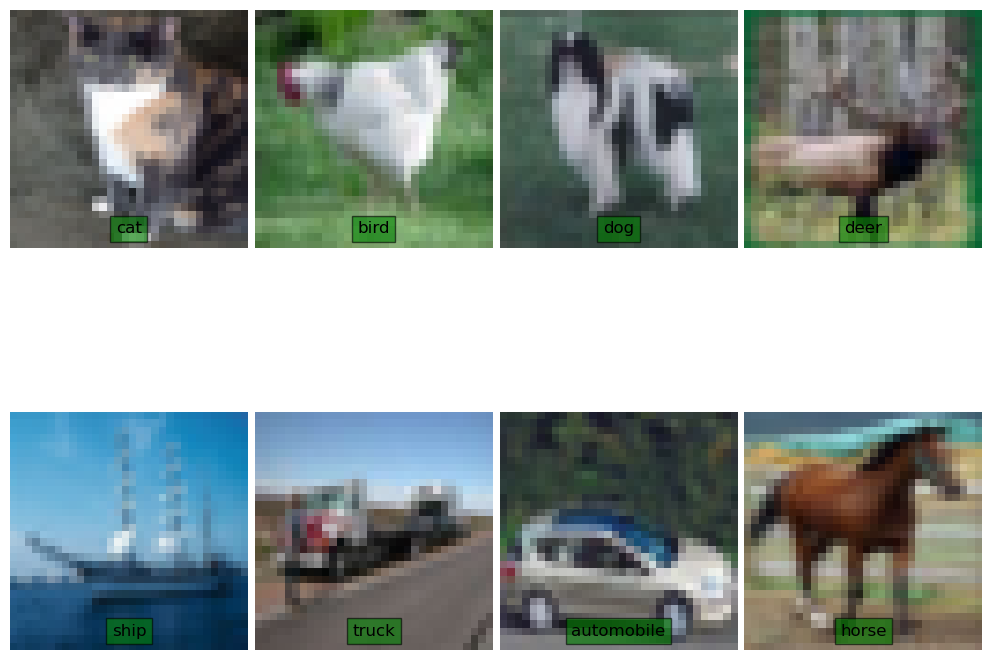

In [14]:
create_subplot_from_df(input_df.iloc[:8,:], image_path_col=IMAGE_PATH_COL, concepts_col=CONCEPT_COL)

The images displayed by default are from the Cifar10 dataset. You can choose to use and test your own application dataset.

## Get Predictions
Now, we will use the DataFrame that we created to run inference on each image.

In [50]:
pred_df = get_preds_df(stub, metadata, input_df)
pred_df.shape

Fetching inputs:   0%|          | 0/9984 [00:00<?, ?it/s]

Predicting on inputs:   0%|          | 0/624 [00:00<?, ?it/s]

Compiling predictions:   0%|          | 0/624 [00:00<?, ?it/s]

(9984, 4)

In [41]:
pred_df.head()

,pred_concept,pred_concept_value,url,input_id
0,deer,0.999620,https://s3.amazonaws.com/clarifai-api/img3/pro...,75b3f44c2c264f27a3274339c1261c81
1,deer,0.999887,https://s3.amazonaws.com/clarifai-api/img3/pro...,6616d19243634eafa19a43869d60cc72
2,cat,0.995298,https://s3.amazonaws.com/clarifai-api/img3/pro...,50b49d4d76514211bcc5792a74396172
3,bird,0.999993,https://s3.amazonaws.com/clarifai-api/img3/pro...,40e05015e52f46fdb00bbfeb74b8ff78
4,bird,0.977549,https://s3.amazonaws.com/clarifai-api/img3/pro...,369cd3cdb27d4f90b08810f66657c8d2


## Combine Predictions and Labels
Let's combine our data with our predictions to build one DataFrame `pred_and_label_df`

In [57]:
pred_and_label_df = pd.merge(input_df, pred_df, on=["input_id", "url"], how="left")
pred_and_label_df.shape

(9984, 6)

In [59]:
pred_and_label_df.sample(10)

,input_id,url,pos_concepts,neg_concepts,pred_concept,pred_concept_value
6832,ee43d3a46d184237be0fb6c2d73b09c2,https://s3.amazonaws.com/clarifai-api/img3/pro...,automobile,,automobile,0.964381
5191,456af07048404632ac2f03f0057accd7,https://s3.amazonaws.com/clarifai-api/img3/pro...,bird,,bird,0.996839
9875,c1da3aad06f3490d9c153af5086d9c84,https://s3.amazonaws.com/clarifai-api/img3/pro...,ship,,ship,0.998649
5280,ee8c71d9522843b7b76530a6fcd3b169,https://s3.amazonaws.com/clarifai-api/img3/pro...,dog,,dog,0.971754
3658,4bd80fcdf538401f8b74c9b7921289f7,https://s3.amazonaws.com/clarifai-api/img3/pro...,bird,,bird,0.997780
551,5883db8d6906451f95dc19b484d4b13e,https://s3.amazonaws.com/clarifai-api/img3/pro...,bird,,bird,0.991042
5382,426b49f75b7e4b7ea625c3bd9f1709dc,https://s3.amazonaws.com/clarifai-api/img3/pro...,deer,,deer,0.945361
7062,ab2de6d479b54cc985e7f79669505fb1,https://s3.amazonaws.com/clarifai-api/img3/pro...,cat,,cat,0.997613
5368,a8531c91ebc44ba6be41066d91d29cf7,https://s3.amazonaws.com/clarifai-api/img3/pro...,frog,,frog,0.999742
8107,316840aecadb4362aa01bd794b33cd8e,https://s3.amazonaws.com/clarifai-api/img3/pro...,deer,,deer,0.999729


## Evaluation
In this sub-section, we will encode the label and predictions and then evaluate the predictions.

### Encoding
We are going to be using Scikit-Learn Label Encoder to encode the true and predicted labels.

In [60]:
pred_and_label_df["pos_concepts"].value_counts()

ship          1000
bird           999
horse          999
frog           999
airplane       999
dog            998
truck          998
automobile     998
cat            997
deer           997
Name: pos_concepts, dtype: int64

In [61]:
le = preprocessing.LabelEncoder()
le.fit(pred_and_label_df["pos_concepts"])
le.classes_

array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
       'horse', 'ship', 'truck'], dtype=object)

In [63]:
pred_and_label_df["pos_concepts_enc"] = le.transform(pred_and_label_df["pos_concepts"])
pred_and_label_df["pred_concept_enc"] = le.transform(pred_and_label_df["pred_concept"])
pred_and_label_df.sample(10)

,input_id,url,pos_concepts,neg_concepts,pred_concept,pred_concept_value,pos_concepts_enc,pred_concept_enc
5105,d4dac2db8c1b488396c95a38638eb80a,https://s3.amazonaws.com/clarifai-api/img3/pro...,deer,,cat,0.258384,4,3
3578,72a89bbb55c14918b0d4597e3b68161d,https://s3.amazonaws.com/clarifai-api/img3/pro...,airplane,,airplane,0.995675,0,0
7698,c84f3dd8e7b24fbfac00a540459fd391,https://s3.amazonaws.com/clarifai-api/img3/pro...,frog,,frog,0.999998,6,6
4555,57c8c7c580024b57bb4dee47387d40da,https://s3.amazonaws.com/clarifai-api/img3/pro...,cat,,cat,0.229096,3,3
9354,43a6604f97164c219c2687f41ae72451,https://s3.amazonaws.com/clarifai-api/img3/pro...,bird,,bird,0.998726,2,2
5206,90e079f869364224b14e3a1553d75fb2,https://s3.amazonaws.com/clarifai-api/img3/pro...,cat,,cat,0.684553,3,3
5120,fecdf1697ff84a26b62ed2337edf59c5,https://s3.amazonaws.com/clarifai-api/img3/pro...,frog,,frog,1.000000,6,6
3094,98b889ff6db3478583b94c2c2cc4b1e3,https://s3.amazonaws.com/clarifai-api/img3/pro...,horse,,horse,0.999920,7,7
228,93543335328c46928c926f632a692cc5,https://s3.amazonaws.com/clarifai-api/img3/pro...,dog,,dog,0.999927,5,5
5858,dd637492c2e34c61b21592b4b03626ba,https://s3.amazonaws.com/clarifai-api/img3/pro...,automobile,,automobile,0.999930,1,1


We can create two dicts that map index to label and vice-versa.

In [64]:
idxtolabel = {idx:label for idx, label in enumerate(le.classes_)}
labeltoidx = {label:idx for idx, label in idxtolabel.items()}
idxtolabel, labeltoidx

({0: 'airplane',
  1: 'automobile',
  2: 'bird',
  3: 'cat',
  4: 'deer',
  5: 'dog',
  6: 'frog',
  7: 'horse',
  8: 'ship',
  9: 'truck'},
 {'airplane': 0,
  'automobile': 1,
  'bird': 2,
  'cat': 3,
  'deer': 4,
  'dog': 5,
  'frog': 6,
  'horse': 7,
  'ship': 8,
  'truck': 9})

### Classification Report
We can now generate a classification report. This allows us to evaluate how the model performed for each class.

In [65]:
classification_report_df = pred_and_label_df.copy()
y_true = classification_report_df["pos_concepts_enc"]
y_pred = classification_report_df["pred_concept_enc"]
print(classification_report(y_true, y_pred, target_names=idxtolabel.values()))

              precision    recall  f1-score   support

    airplane       0.96      0.97      0.96       999
  automobile       0.98      0.97      0.97       998
        bird       0.97      0.95      0.96       999
         cat       0.89      0.92      0.91       997
        deer       0.93      0.96      0.95       997
         dog       0.94      0.91      0.92       998
        frog       0.98      0.98      0.98       999
       horse       0.98      0.95      0.97       999
        ship       0.97      0.97      0.97      1000
       truck       0.97      0.97      0.97       998

    accuracy                           0.96      9984
   macro avg       0.96      0.96      0.96      9984
weighted avg       0.96      0.96      0.96      9984



### Confusion Matrix
We can now generate the confusion matrix. This allows us to evaluate which classes are getting "confused" by the model.

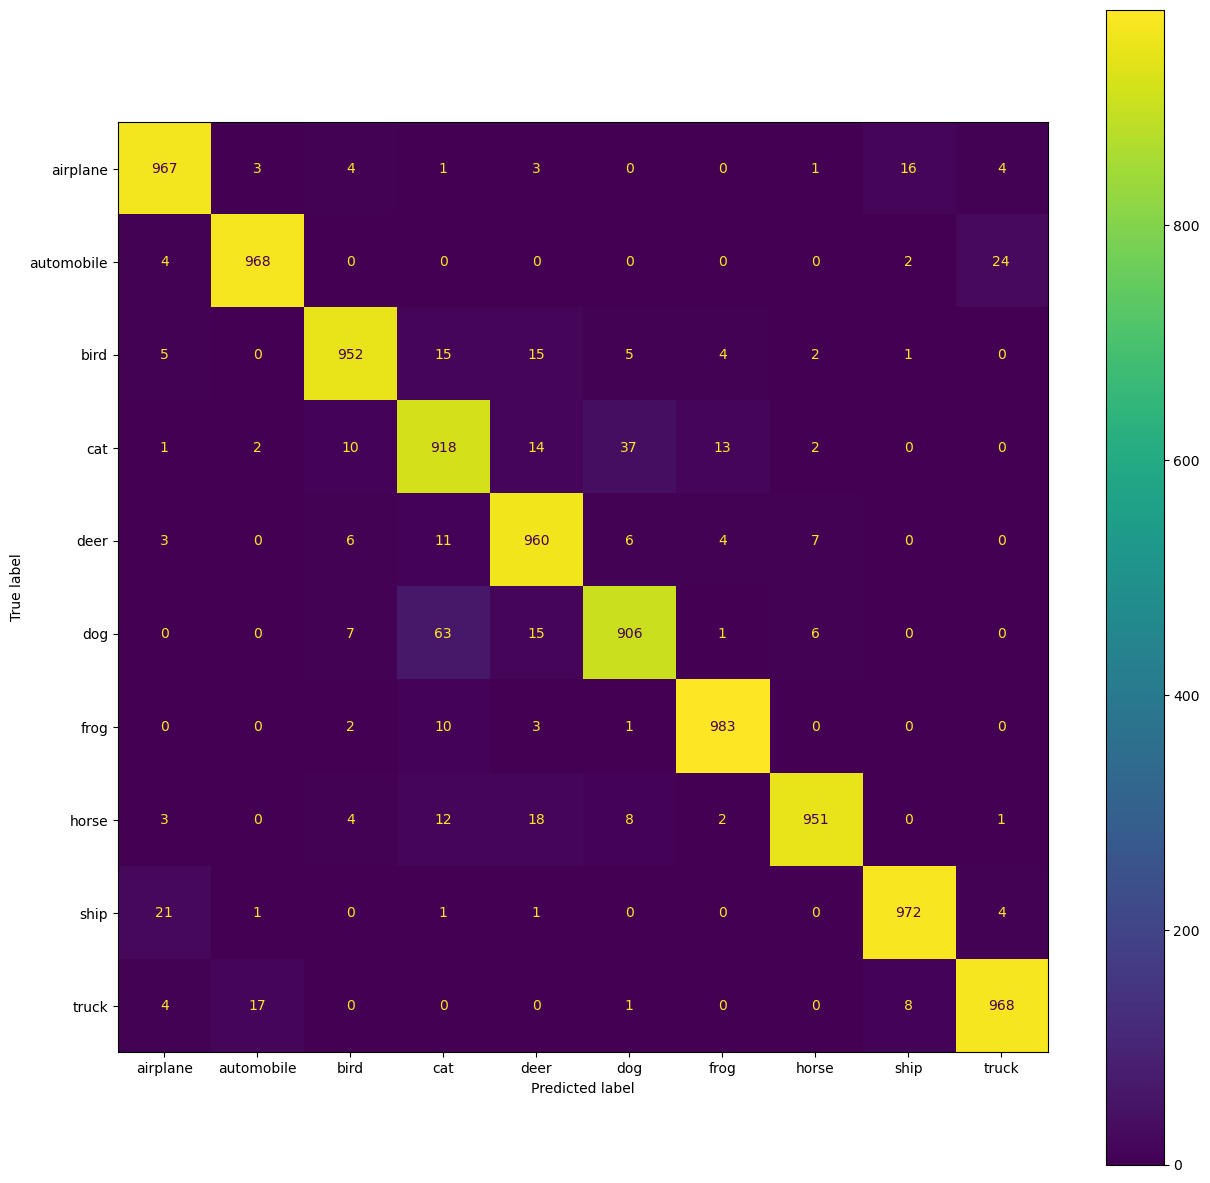

In [66]:
confusion_matrix_ = confusion_matrix(y_true, y_pred)
plt.rcParams["figure.figsize"] = (15, 15)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_, display_labels=idxtolabel.values())
cm_display.plot()
plt.show()

Analyzing the confusion matrix, we notice that the model predicts cats as dogs and trucks as automobile. Those are expected false positives that make sense since cat and dog are both animals and a truck and an automobile are both types of cars.

# Inference via Local DataFrame

## Setup
Let's setup some global variables that we will be using. Notably, the column name for the image paths and concepts.

In [67]:
IMAGE_PATH_COL = "url"
CONCEPT_COL = "pos_concepts"

## Get Inputs
Here, we will first download the test csv file and then load it in a Dataframe. You can choose to use your own test csv file as well.

### Download CSV File

First let's download the csv file that we will be using.


In [68]:
!mkdir -p ./data
!wget -q -O ./data/test_df.csv https://s3.amazonaws.com/samples.clarifai.com/api-training/test_df.csv

### Prepare

Let's prepare the dataframe that we will be using for inference.

In [69]:
DATA_DIR = Path("./data")
TEST_DATA_PATH = DATA_DIR / "test_df.csv"

In [70]:
test_df = pd.read_csv(TEST_DATA_PATH)
test_df.shape

(7, 4)

We'll have to rename two columns. This is so that are test_df and predictions share the same column names.

In [71]:
test_df.rename(columns={"image_path": "url", "concepts": "pos_concepts"}, inplace=True)

In [72]:
test_df

,url,pos_concepts,extension,random_text
0,https://s3.amazonaws.com/samples.clarifai.com/...,dog,.jpg,random1
1,https://s3.amazonaws.com/samples.clarifai.com/...,dog,.jpg,random2
2,https://s3.amazonaws.com/samples.clarifai.com/...,cat,.jpg,random3
3,https://s3.amazonaws.com/samples.clarifai.com/...,cat,.jpg,random4
4,https://s3.amazonaws.com/samples.clarifai.com/...,both,.jpg,random5
5,https://s3.amazonaws.com/samples.clarifai.com/...,dog,.jpg,random6
6,https://s3.amazonaws.com/samples.clarifai.com/...,dog,.jpg,random7


We have 7 images with 4 columns. There is the `image_path`, the `concepts` and two additional columns that will be used as **metadata**.

## View Images

Now that we have the dataframe ready, we can view some images of the images.


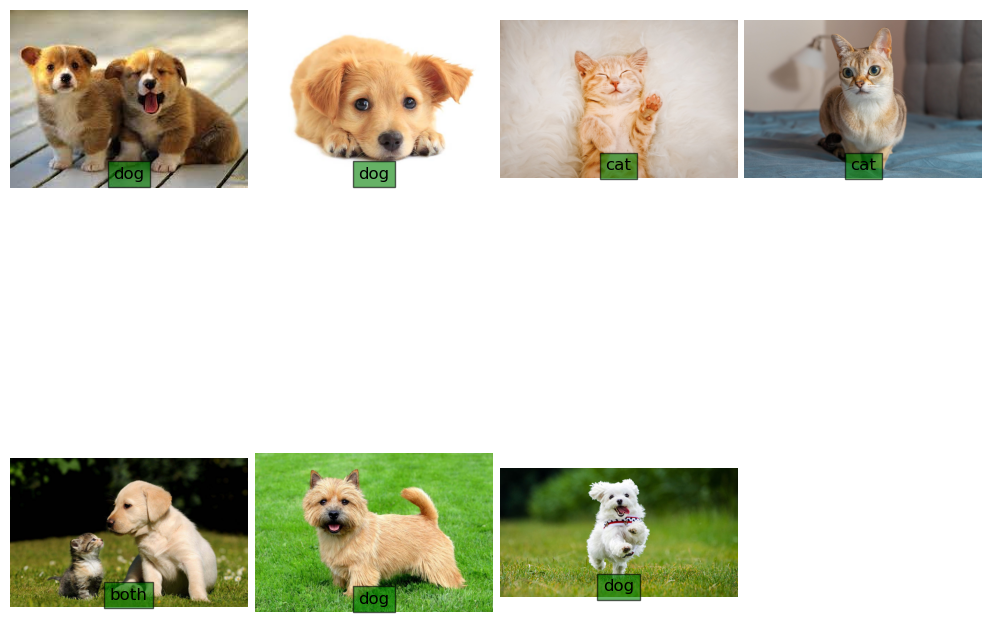

In [73]:
create_subplot_from_df(test_df, image_path_col=IMAGE_PATH_COL, concepts_col=CONCEPT_COL)

## Get Predictions
Now, we will use the DataFrame that we created to run inference on each image.

In [74]:
pred_df = get_preds_df(stub, metadata, test_df, IMAGE_PATH_COL)
pred_df.shape

Fetching inputs:   0%|          | 0/7 [00:00<?, ?it/s]

Predicting on inputs:   0%|          | 0/1 [00:00<?, ?it/s]

Compiling predictions:   0%|          | 0/1 [00:00<?, ?it/s]

(7, 4)

In [75]:
pred_df.head()

,pred_concept,pred_concept_value,url,input_id
0,dog,0.998829,https://s3.amazonaws.com/samples.clarifai.com/...,c074a769bcd1437ea8fded1affdbdfef
1,dog,0.997717,https://s3.amazonaws.com/samples.clarifai.com/...,5aafef608f8d453d9d36afcaf259577c
2,cat,0.999279,https://s3.amazonaws.com/samples.clarifai.com/...,1ea9cf97b1944d45a3304a9c68916c71
3,cat,0.999741,https://s3.amazonaws.com/samples.clarifai.com/...,a0ea955f67de456fad27c47736ee0bf0
4,dog,0.985147,https://s3.amazonaws.com/samples.clarifai.com/...,8a1ab2654c73467bae32ffc736d5a42a


## Combine Predictions and Labels
Let's combine our data with our predictions to build one DataFrame `pred_and_label_df`## Combine Predictions and Labels

In [76]:
pred_and_label_df = pd.merge(test_df, pred_df, on=["url"], how="left")
pred_and_label_df.shape

(7, 7)

In [77]:
pred_and_label_df.head()

,url,pos_concepts,extension,random_text,pred_concept,pred_concept_value,input_id
0,https://s3.amazonaws.com/samples.clarifai.com/...,dog,.jpg,random1,dog,0.998829,c074a769bcd1437ea8fded1affdbdfef
1,https://s3.amazonaws.com/samples.clarifai.com/...,dog,.jpg,random2,dog,0.997717,5aafef608f8d453d9d36afcaf259577c
2,https://s3.amazonaws.com/samples.clarifai.com/...,cat,.jpg,random3,cat,0.999279,1ea9cf97b1944d45a3304a9c68916c71
3,https://s3.amazonaws.com/samples.clarifai.com/...,cat,.jpg,random4,cat,0.999741,a0ea955f67de456fad27c47736ee0bf0
4,https://s3.amazonaws.com/samples.clarifai.com/...,both,.jpg,random5,dog,0.985147,8a1ab2654c73467bae32ffc736d5a42a


In [90]:
pred_and_label_df["pos_concepts"].value_counts()

dog     4
cat     2
both    1
Name: pos_concepts, dtype: int64

In [79]:
pred_and_label_df["pred_concept"].value_counts()

dog    5
cat    2
Name: pred_concept, dtype: int64

## Evaluation
In this sub-section, we will encode the label and predictions and then evaluate the predictions.

### Encoding
We are going to be using Scikit-Learn Label Encoder to encode the true and predicted labels.

In [80]:
le = preprocessing.LabelEncoder()
le.fit(pred_and_label_df["pos_concepts"])
le.classes_

array(['both', 'cat', 'dog'], dtype=object)

In [81]:
pred_and_label_df["pos_concepts_enc"] = le.transform(pred_and_label_df["pos_concepts"])
pred_and_label_df["pred_concept_enc"] = le.transform(pred_and_label_df["pred_concept"])
pred_and_label_df

,url,pos_concepts,extension,random_text,pred_concept,pred_concept_value,input_id,pos_concepts_enc,pred_concept_enc
0,https://s3.amazonaws.com/samples.clarifai.com/...,dog,.jpg,random1,dog,0.998829,c074a769bcd1437ea8fded1affdbdfef,2,2
1,https://s3.amazonaws.com/samples.clarifai.com/...,dog,.jpg,random2,dog,0.997717,5aafef608f8d453d9d36afcaf259577c,2,2
2,https://s3.amazonaws.com/samples.clarifai.com/...,cat,.jpg,random3,cat,0.999279,1ea9cf97b1944d45a3304a9c68916c71,1,1
3,https://s3.amazonaws.com/samples.clarifai.com/...,cat,.jpg,random4,cat,0.999741,a0ea955f67de456fad27c47736ee0bf0,1,1
4,https://s3.amazonaws.com/samples.clarifai.com/...,both,.jpg,random5,dog,0.985147,8a1ab2654c73467bae32ffc736d5a42a,0,2
5,https://s3.amazonaws.com/samples.clarifai.com/...,dog,.jpg,random6,dog,0.974623,99cfa91b89b64ff09fceaece8f1b9968,2,2
6,https://s3.amazonaws.com/samples.clarifai.com/...,dog,.jpg,random7,dog,0.999963,61c0100715c540d4a1637578f987502f,2,2


We can create two dicts that map index to label and vice-versa.

In [82]:
idxtolabel = {idx:label for idx, label in enumerate(le.classes_)}
labeltoidx = {label:idx for idx, label in idxtolabel.items()}
idxtolabel, labeltoidx

({0: 'both', 1: 'cat', 2: 'dog'}, {'both': 0, 'cat': 1, 'dog': 2})

### Classification Report
We can now generate a classification report. This allows us to evaluate how the model performed for each class.

In [83]:
classification_report_df = pred_and_label_df.copy()
y_true = classification_report_df["pos_concepts_enc"]
y_pred = classification_report_df["pred_concept_enc"]
print(classification_report(y_true, y_pred, target_names=idxtolabel.values(), zero_division=0))

              precision    recall  f1-score   support

        both       0.00      0.00      0.00         1
         cat       1.00      1.00      1.00         2
         dog       0.80      1.00      0.89         4

    accuracy                           0.86         7
   macro avg       0.60      0.67      0.63         7
weighted avg       0.74      0.86      0.79         7



### Confusion Matrix
We can now generate the confusion matrix. This allows us to evaluate which classes are getting "confused" by the model.

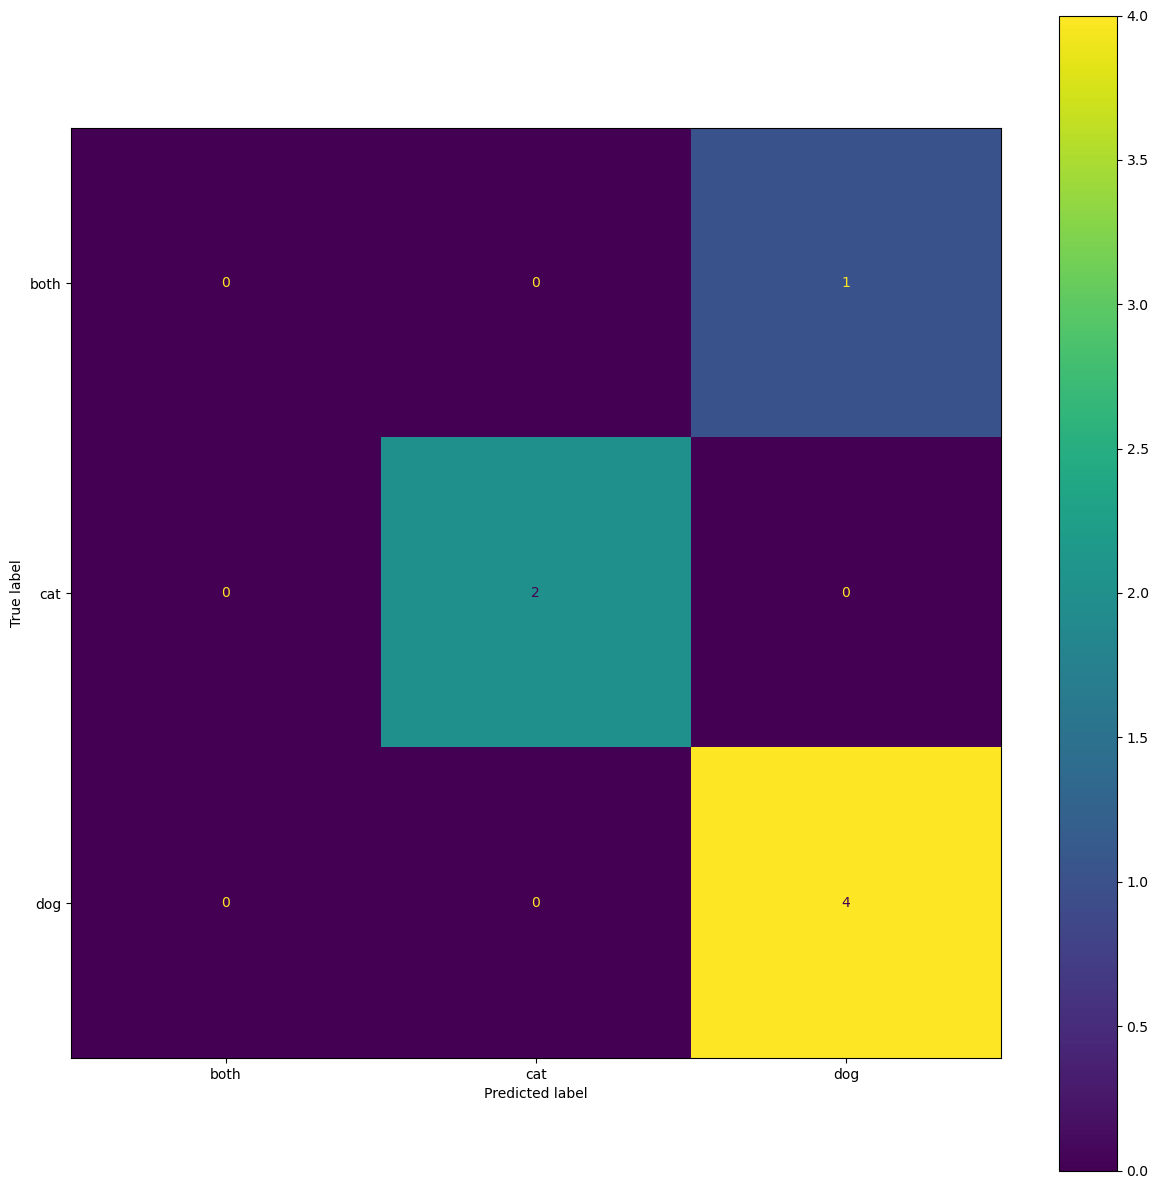

In [84]:
confusion_matrix_ = confusion_matrix(y_true, y_pred)
plt.rcParams["figure.figsize"] = (15, 15)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_, display_labels=idxtolabel.values())
cm_display.plot()
plt.show()

Analyzing this confusion matrix, we notice that the image that was labeled as `both` was predicted as a dog. The model that was used was not trained to predict the class `both`. In this case, we notice that the dog in the image takes much more space than the cat, resulting on the model predicting the concept `dog`.

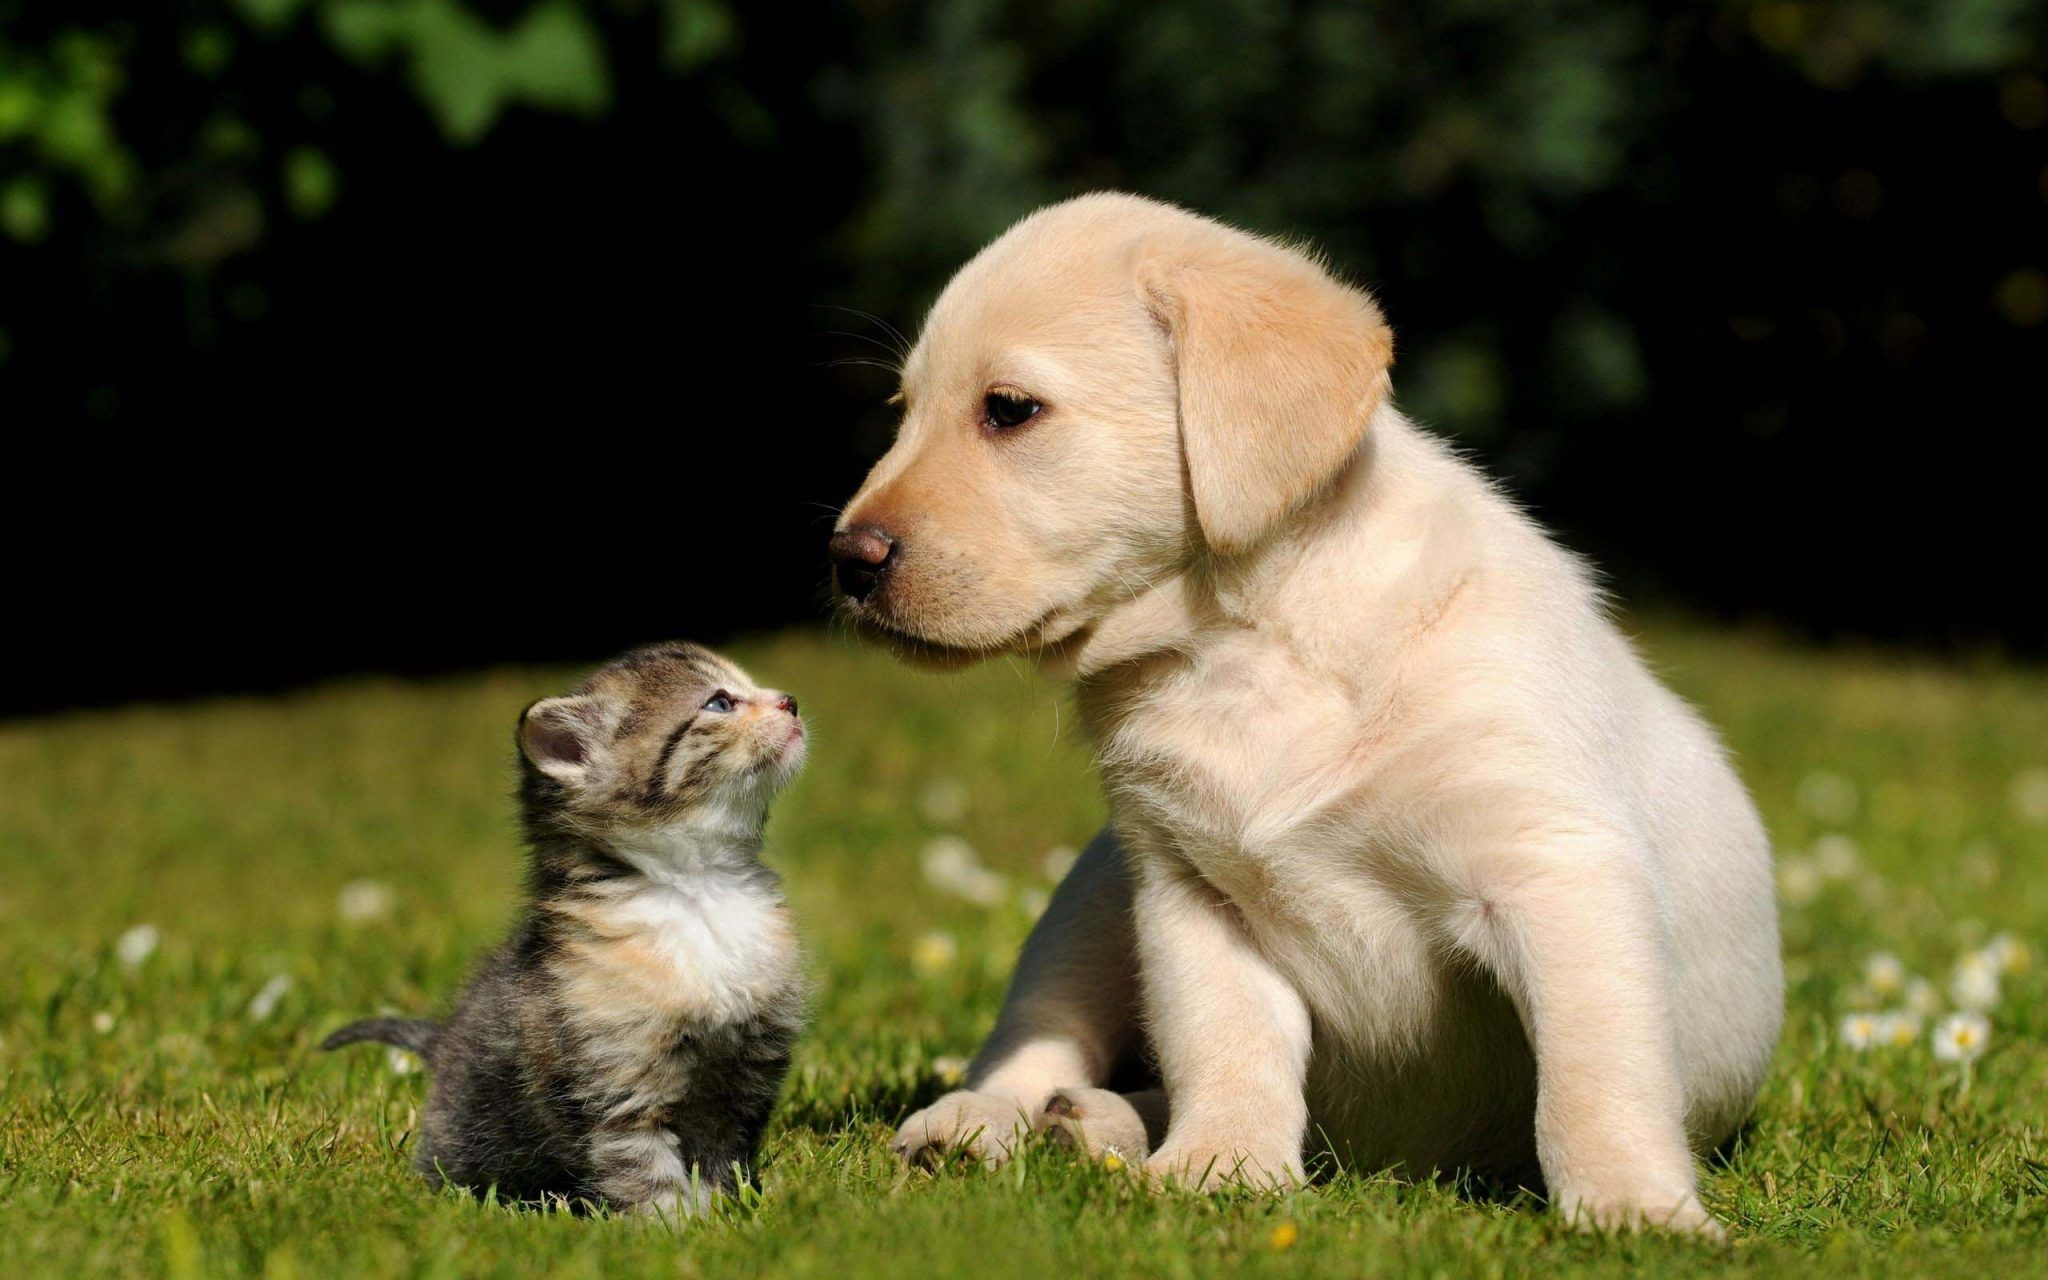

In [89]:
url_to_image(pred_and_label_df[pred_and_label_df["pos_concepts"] == "both"]["url"].iloc[0])